In [0]:
!gdown https://drive.google.com/uc?id=1rJrn1oeB_7N5YaF2a0T2QsKRfurejnOW
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("")
    

In [0]:
import numpy as np # Thinly−wrapped numpy
import pandas as pd
from matplotlib import cm 
import matplotlib as mpl
%matplotlib inline 
from matplotlib import pyplot as plt 


In [0]:
from RFF import*

In [0]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ShuffleSplit,  GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from  data_loader import load_data


X_train, X_test, y_train, y_test=load_data("data/LP-RFFs-Data/yearpred")


In [0]:
X_train=X_train[0:17343]
y_train=y_train[0:17343]


X_test=X_train[0:6372]
y_test=y_train[0:6372]


In [0]:
y_train=y_train.reshape(-1)
y_test=y_test.reshape(-1)

In [0]:
print(" Train: X.shape = {} | y.shape = {} | number of classes : {}".format(X_train.shape, y_train.shape, len(np.unique(y_train))))
print(" Test: X.shape = {} | y.shape = {} | number of classes : {}".format(X_test.shape, y_test.shape, len(np.unique(y_test))))

 Train: X.shape = (17343, 90) | y.shape = (17343,) | number of classes : 72
 Test: X.shape = (6372, 90) | y.shape = (6372,) | number of classes : 64


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
Ds = [2**i for i in range(5,12)]
lDs = len(Ds)
n_repeats = 10
rff_times1, rff_errors1 = np.zeros((lDs,n_repeats)), np.zeros((lDs,n_repeats))

for i,D in enumerate(Ds):
    print(D)
    rff_pip1 = Pipeline([
                ('std',StandardScaler()),
                ('rff',RFF(gamma=gamma, metric = 'rbf', D=D)),
                ('linsvc', LinearSVR(C=5)),
             ])

    for n in range(n_repeats):
        t = time()
        rff_pip1.fit(X_train, y_train)
        t_rff1 = time() - t
        rff_times1[i,n] = t_rff1

        y_pred_rff1 = rff_pip1.predict(X_test)                      
        error_rff1 =  rmse(y_test, y_pred_rff1) 
        rff_errors1[i,n] = error_rff1



32
64
128
256
512
1024
2048


In [0]:
np.save('rff_usps_errors', rff_errors1)
np.save('rff_usps_times', rff_times1)

print("Best RFF performance: Testing error = %f | Training time = %f"%(rff_errors1[-1,-1],rff_times1[-1,-1]))

Best RFF performance: Testing error = 80.319223 | Training time = 5.379159


# Nystroem

In [0]:
from sklearn.kernel_approximation import Nystroem
Ds = [2**i for i in range(5,12)]
lDs = len(Ds)
n_repeats = 10
Nystroem_times1, Nystroem_errors1 = np.zeros((lDs,n_repeats)), np.zeros((lDs,n_repeats))

for i,D in enumerate(Ds):
    print(D)
    Nystroem_pip1 = Pipeline([
                ('std',StandardScaler()),
                ('nystroem',Nystroem(gamma=gamma, kernel='rbf',n_components=D) ),
                ('linsvc', LinearSVR(C=5)),
             ])

    for n in range(n_repeats):
        t = time()
        Nystroem_pip1.fit(X_train, y_train)
        t_Nystroem1 = time() - t
        Nystroem_times1[i,n] = t_Nystroem1

        y_pred_Nystroem1 = Nystroem_pip1.predict(X_test)                      
        error_Nystroem1 = rmse(y_test, y_pred_Nystroem1) 
        Nystroem_errors1[i,n] = error_Nystroem1

np.save('Nystroem_usps_errors', Nystroem_errors1)
np.save('Nystroem_usps_times', Nystroem_times1)

print("Best Nystroem performance: Testing error = %f | Training time = %.3f"%(Nystroem_errors1[-1,-1],Nystroem_times1[-1,-1]))

32
64
128
256
512
1024
2048
Best Nystroem performance: Testing error = 80.058281 | Training time = 14.042


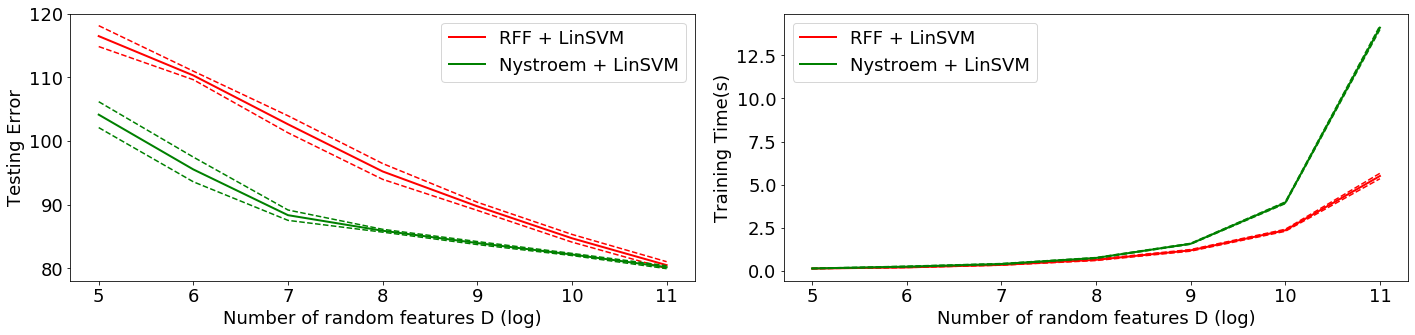

In [0]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages("svm_yearpred.pdf")
logDs = np.arange(5,12)
mpl.rcParams.update({'font.size': 18})
f = plt.figure(figsize=(20,5))
plt.subplot(121)

mean = rff_errors1.mean(axis=-1)
std = rff_errors1.std(axis=-1)

mean_ = Nystroem_errors1.mean(axis=-1)
std_ = Nystroem_errors1.std(axis=-1)

plt.plot(logDs, mean, 'r', linewidth = 2,label="RFF + LinSVM")
plt.plot(logDs, mean-std, 'r--')
plt.plot(logDs, mean+std, 'r--')

plt.plot(logDs, mean_, 'g', linewidth = 2,label="Nystroem + LinSVM")
plt.plot(logDs, mean_-std_, 'g--')
plt.plot(logDs, mean_+std_, 'g--')

plt.ylabel("Testing Error")
plt.xlabel("Number of random features D (log)")
plt.legend()
plt.subplot(122)

mean = rff_times1.mean(axis=-1)
std = rff_times1.std(axis=-1)

mean_ = Nystroem_times1.mean(axis=-1)
std_ = Nystroem_times1.std(axis=-1)

plt.plot(logDs, mean, 'r', linewidth=2, label="RFF + LinSVM")
plt.plot(logDs, mean-std, 'r--')
plt.plot(logDs, mean+std, 'r--')

plt.plot(logDs, mean_, 'g', linewidth=2, label="Nystroem + LinSVM")
plt.plot(logDs, mean_-std_, 'g--')
plt.plot(logDs, mean_+std_, 'g--')


plt.ylabel("Training Time(s)")
plt.xlabel("Number of random features D (log)")
plt.legend()
#plt.legend(bbox_to_anchor=[1.4,1.])
plt.tight_layout()
pp.savefig(f)
pp.close()
plt.show()
